# COVID-19 

This is my new version of analyses of COVID-19.  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from pathlib import Path
import numpy as np
import pandas as pd
import datetime
import time

# Canada

In [2]:
from src.phac import PHAC


can = PHAC()
as_of = "2020-07-06"

## Total Cases

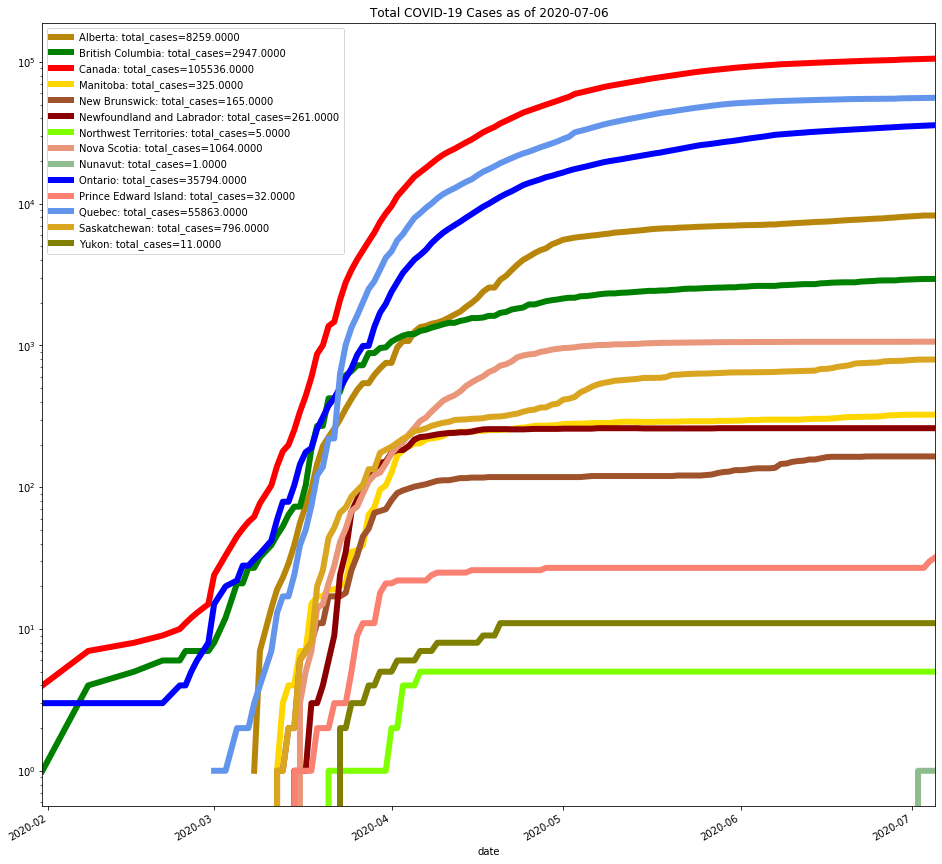

In [3]:
can_tc_fig = can.plot_var("total_cases", *can.provinces,
    figsize=(16,16),
    log_scale=True,
    colours=can.prov_colours,
    #date_start="2020-03-01",
    lw=6,
    title=f"Total COVID-19 Cases as of {as_of}"  
)


plt.show()

In [4]:
var_pivot = can.var_by_location("total_cases", *can.provinces)
var_pivot[-7:][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-06-28,103250.0,261.0,27.0,1061.0,165.0,55079.0,34654.0,322.0,778.0,7996.0,2878.0,11.0,5.0,0.0
2020-06-29,103918.0,261.0,27.0,1061.0,165.0,55390.0,34911.0,324.0,779.0,8067.0,2904.0,11.0,5.0,0.0
2020-06-30,104204.0,261.0,27.0,1062.0,165.0,55458.0,35068.0,325.0,785.0,8108.0,2916.0,11.0,5.0,0.0
2020-07-02,104772.0,261.0,27.0,1064.0,165.0,55593.0,35370.0,325.0,795.0,8202.0,2940.0,11.0,5.0,1.0
2020-07-03,105091.0,261.0,27.0,1064.0,165.0,55682.0,35535.0,325.0,796.0,8259.0,2947.0,11.0,5.0,1.0
2020-07-04,105317.0,261.0,30.0,1064.0,165.0,55784.0,35656.0,325.0,796.0,8259.0,2947.0,11.0,5.0,1.0
2020-07-05,105536.0,261.0,32.0,1064.0,165.0,55863.0,35794.0,325.0,796.0,8259.0,2947.0,11.0,5.0,1.0


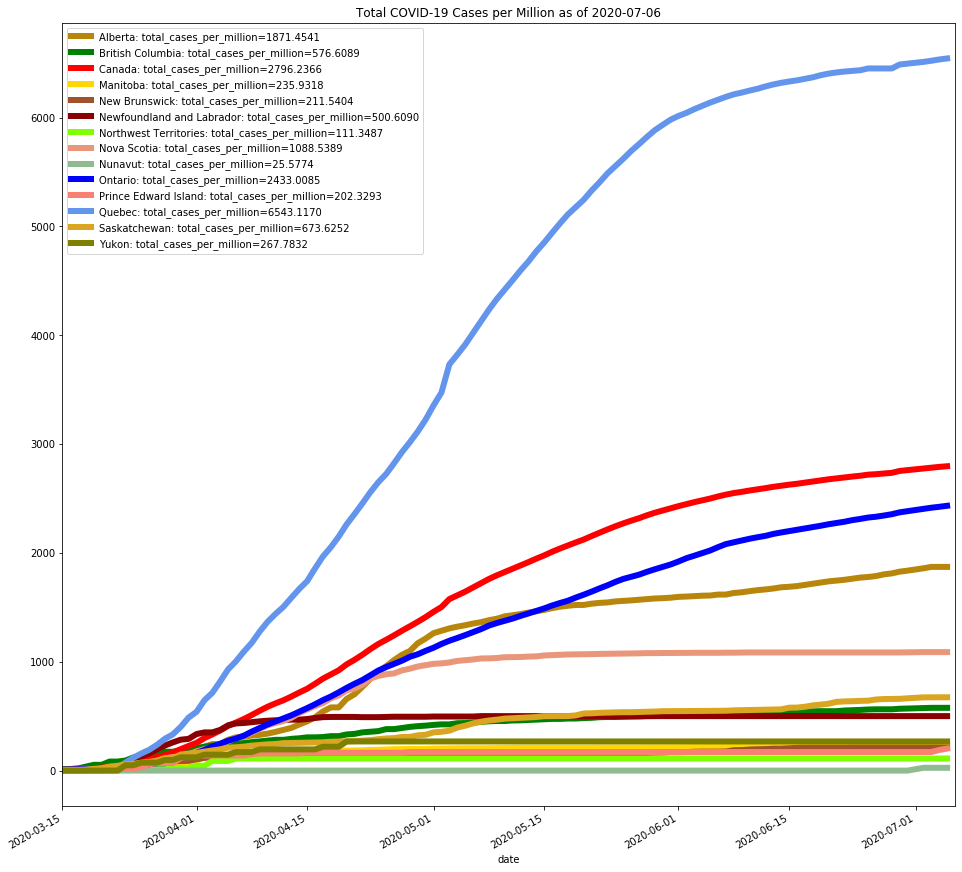

In [5]:
can_tcpm_fig = can.plot_var("total_cases_per_million", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-15",
    date_end=as_of,
    lw=6,
    title=f"Total COVID-19 Cases per Million as of {as_of}"  
)


plt.show()

## New cases

In [6]:
can.prov_colours

{'Canada': 'r',
 'Newfoundland and Labrador': 'darkred',
 'Prince Edward Island': 'salmon',
 'Nova Scotia': 'darksalmon',
 'New Brunswick': 'sienna',
 'Quebec': 'cornflowerblue',
 'Ontario': 'b',
 'Manitoba': 'gold',
 'Saskatchewan': 'goldenrod',
 'Alberta': 'darkgoldenrod',
 'British Columbia': 'g',
 'Yukon': 'olive',
 'Northwest Territories': 'chartreuse',
 'Nunavut': 'darkseagreen'}

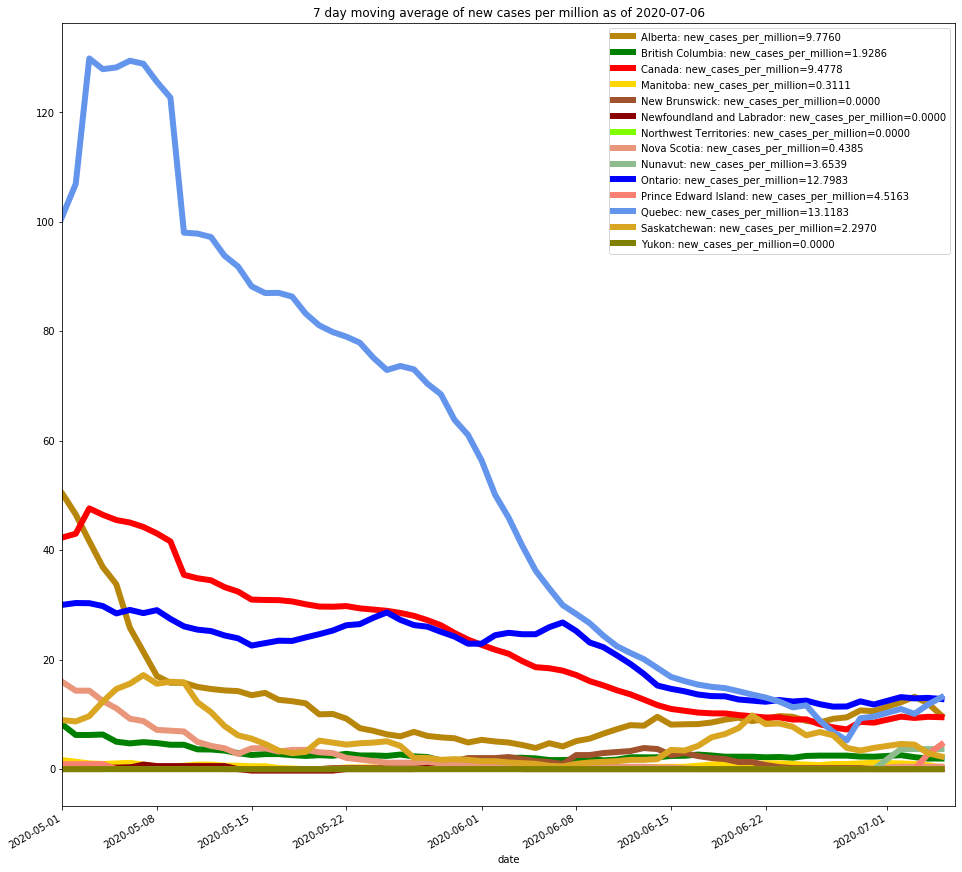

In [7]:
ma_win = 7
can_nc_fig = can.plot_var("new_cases_per_million", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-05-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new cases per million as of {as_of}"  
)

savefile = f"{as_of}_COVID-19_NCperMil_{ma_win}_days.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

In [8]:
ma_win = 7
can_ptg = can.cum_pos_test_growth_rate(ma_win, *can.provinces)
can_ptg

/Users/bill/IdeaProjects/covid-19/src/dataset.py:191: RuntimeWarning: invalid value encountered in power
  growth = lambda x: np.power(x, 1 / window)


location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,-0.009302,-0.005071,-0.013648,-0.005769,-0.006131,-0.012162,-0.008509,-0.005415,NaN,-0.018124,-0.021143,-0.007675,-0.003629,-0.003439
2020-07-02,-0.010545,-0.006082,-0.015495,-0.007410,-0.006721,-0.014684,-0.005075,-0.005555,0.10409,-0.020376,-0.025445,-0.009009,-0.003859,-0.003308
2020-07-03,-0.009800,-0.006524,-0.015168,-0.007973,-0.006588,-0.012842,-0.005302,-0.005157,0.10409,-0.019525,-0.028538,-0.009356,-0.003880,-0.003305


In [9]:
can_nc = can.var_by_location("new_cases", *can.provinces)
can_nc[-7:][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-06-28,218.0,0.0,0.0,0.0,0.0,0.0,178.0,0.0,1.0,39.0,0.0,0.0,0.0,0.0
2020-06-29,668.0,0.0,0.0,0.0,0.0,311.0,257.0,2.0,1.0,71.0,26.0,0.0,0.0,0.0
2020-06-30,286.0,0.0,0.0,1.0,0.0,68.0,157.0,1.0,6.0,41.0,12.0,0.0,0.0,0.0
2020-07-02,568.0,0.0,0.0,2.0,0.0,135.0,302.0,0.0,10.0,94.0,24.0,0.0,0.0,1.0
2020-07-03,319.0,0.0,0.0,0.0,0.0,89.0,165.0,0.0,1.0,57.0,7.0,0.0,0.0,0.0
2020-07-04,226.0,0.0,3.0,0.0,0.0,102.0,121.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-05,219.0,0.0,2.0,0.0,0.0,79.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Tests

In [10]:
ma_win = 14

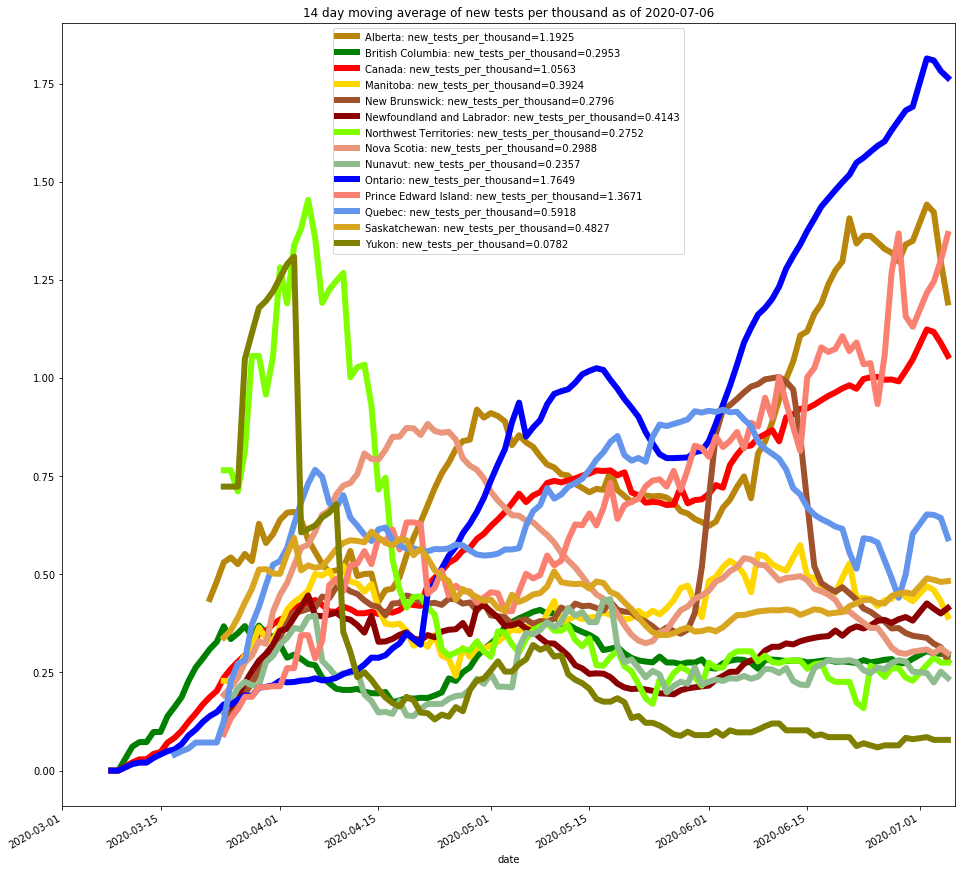

In [11]:

can_nt_fig = can.plot_var("new_tests_per_thousand", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new tests per thousand as of {as_of}"  
)


plt.show()

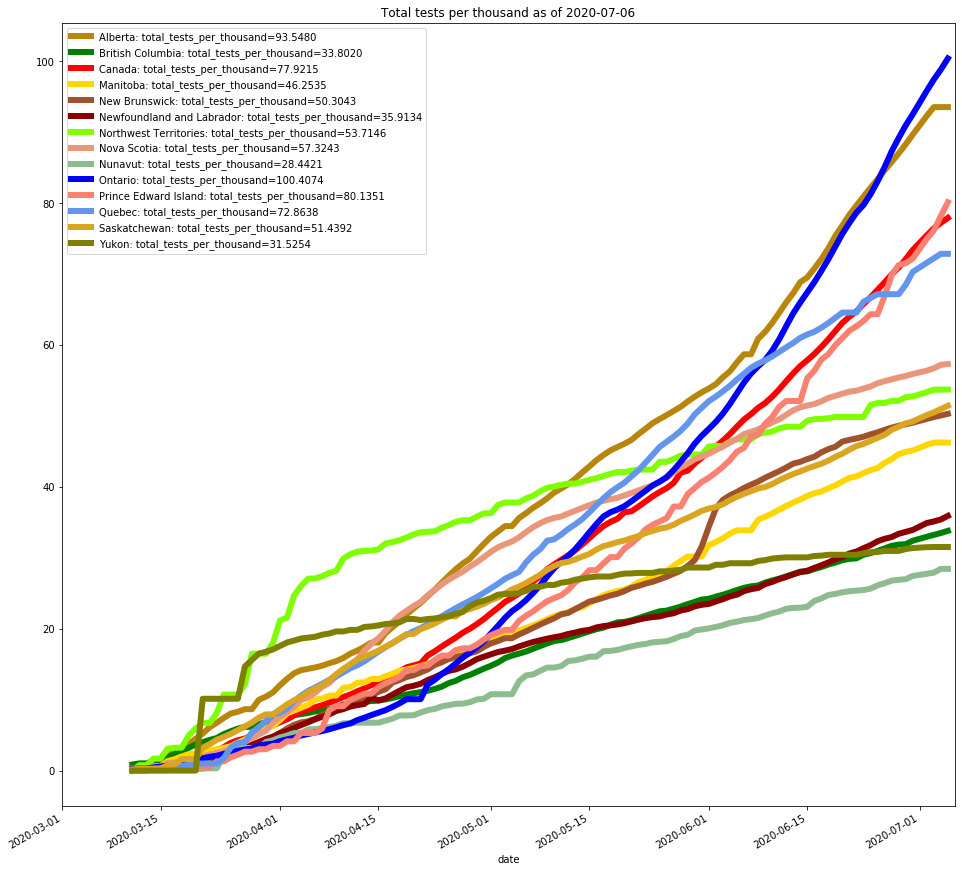

In [12]:
can_ttpt_fig = can.plot_var("total_tests_per_thousand", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"Total tests per thousand as of {as_of}"  
)


plt.show()

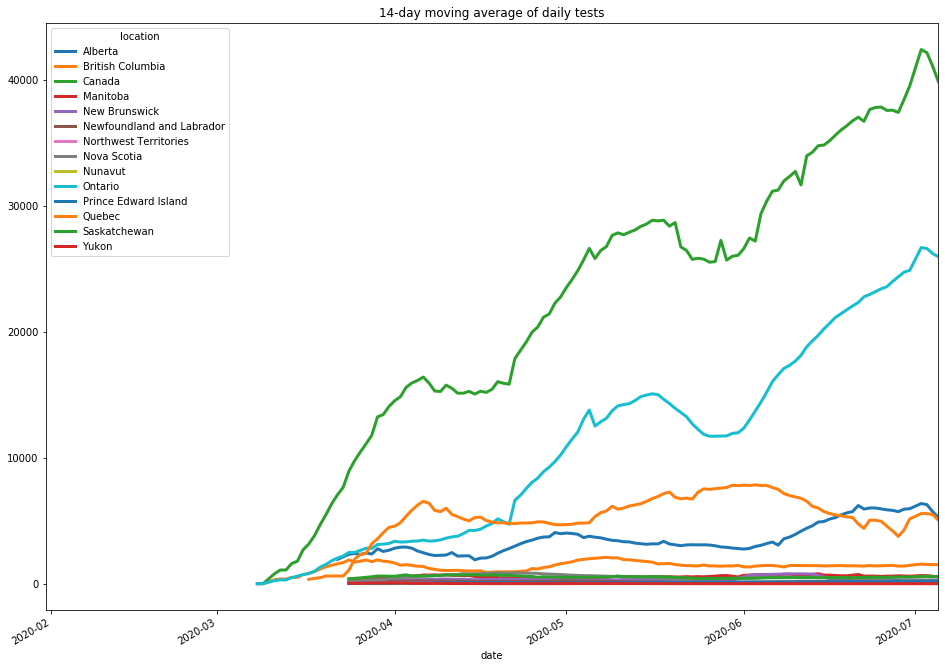

In [13]:
# Plot Daily Tests - Use Average over last ma_win days
ma_win = 14
locations = can.provinces

can_nt = can.var_by_location("new_tests", *locations).rolling(ma_win).mean()

start_date = can_nt.index[0]
end_date = can_nt.index[-1]

plot_properties = dict(
    figsize=(16,12),
    xlim=(start_date, end_date),
    logy=False,
    lw=3,
    #color=[can.prov_colours[loc] for loc in locations],
    title=f"{ma_win}-day moving average of daily tests",
)

fig = can_nt.plot(**plot_properties)

#legend_labels = [f"{loc}: Daily Tests={can_nt.to_dict()[loc][max(can_nt[:end_date].index)]:.4f}"
#                 for loc in sorted(locations)]
#plt.legend(legend_labels)

plt.show()

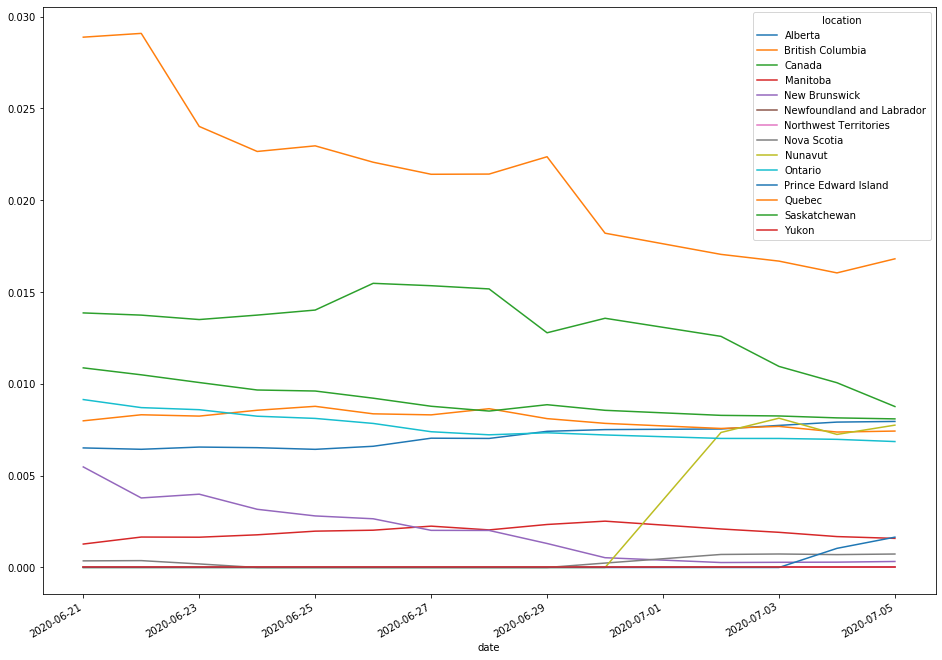

In [14]:
# Plot the positive test rate over the last ma_win days
ma_win = 14
locations = can.provinces

can_nt_rtot = can.var_by_location("new_tests", *locations).rolling(ma_win).sum()
can_nc_rtot = can.var_by_location("total_cases", *locations).diff(periods=ma_win)
can_pt_rolling = can_nc_rtot / (can_nt_rtot)


can_pt_rolling[-14:].plot(figsize=(16,12))

[[0.03133874 0.02930081 0.03187861 0.00632342 0.00130937 0.
  0.         0.00293062 0.03055527 0.02707829 0.00658651 0.06513219
  0.03448354 0.        ]]
['Alberta', 'British Columbia', 'Canada', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon']


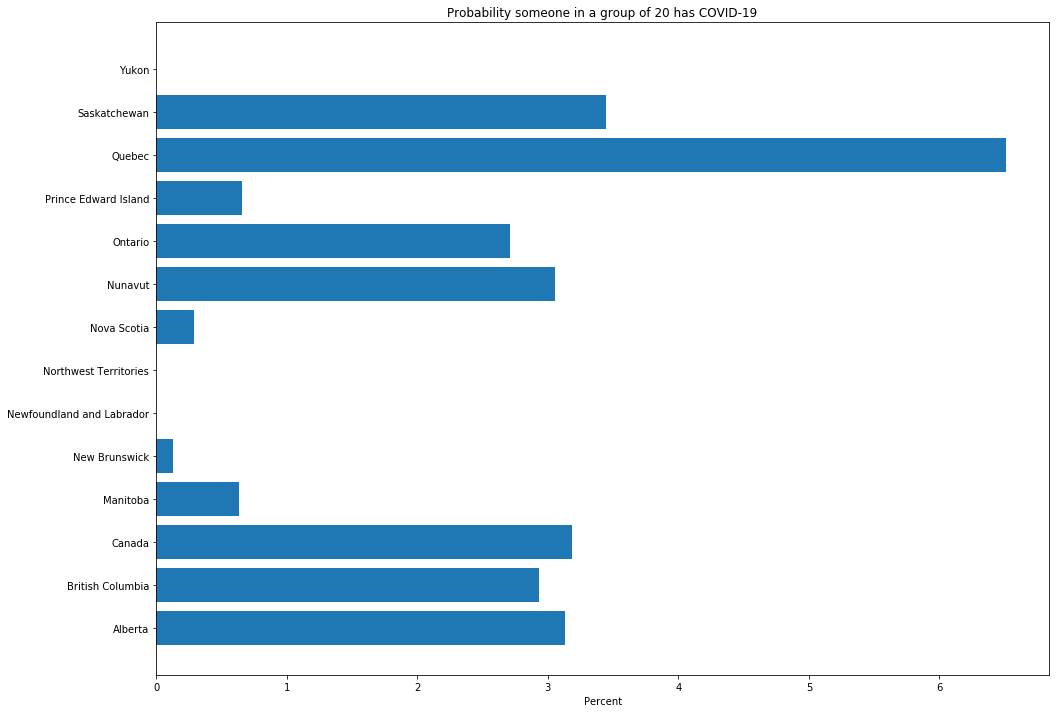

In [15]:
def prob_exposure(group_size, ptr, isolation_compliance=0.8):
    return 1 - np.power(1 - ptr + isolation_compliance * ptr, group_size)

group_size = 20
can_pe = can_pt_rolling.apply(lambda ptr: prob_exposure(group_size, ptr))

print(can_pe[-1:].values)
print(list(can_pe.columns))


pe_fig, pe_ax = plt.subplots(figsize=(16,12))

pe_ax.barh(list(can_pe.columns), 100 * can_pe[-1:].values[0])
pe_ax.set_xlabel("Percent")
pe_ax.set_title(f"Probability someone in a group of {group_size} has COVID-19")

savefile = f"{as_of}_COVID-19_ProbExp_{group_size}.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

In [16]:
can.active_confirmed_cases(*can.provinces)[-14:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-06-21,566.0,158.0,5638.0,13.0,27.0,0.0,0.0,2.0,0.0,2859.0,0.0,1917.0,96.0,0.0
2020-06-22,534.0,163.0,5393.0,14.0,18.0,0.0,0.0,2.0,0.0,2777.0,0.0,1788.0,97.0,0.0
2020-06-23,552.0,166.0,5310.0,14.0,18.0,0.0,0.0,1.0,0.0,2763.0,0.0,1699.0,97.0,0.0
2020-06-24,549.0,169.0,5117.0,15.0,14.0,0.0,0.0,0.0,0.0,2675.0,0.0,1596.0,99.0,0.0
2020-06-25,535.0,175.0,5092.0,16.0,12.0,0.0,0.0,0.0,0.0,2661.0,0.0,1594.0,99.0,0.0
2020-06-26,542.0,169.0,4851.0,17.0,11.0,0.0,0.0,0.0,0.0,2590.0,0.0,1413.0,109.0,0.0
2020-06-27,574.0,169.0,4622.0,19.0,8.0,0.0,0.0,0.0,0.0,2484.0,0.0,1255.0,113.0,0.0
2020-06-28,563.0,169.0,4463.0,18.0,8.0,0.0,0.0,0.0,0.0,2465.0,0.0,1127.0,113.0,0.0
2020-06-29,614.0,159.0,4771.0,20.0,5.0,0.0,0.0,0.0,0.0,2541.0,0.0,1336.0,96.0,0.0


In [17]:
can.active_growth_rate(7, *can.provinces)[-14:]

/Users/bill/IdeaProjects/covid-19/src/dataset.py:160: RuntimeWarning: invalid value encountered in power
  growth = lambda x: np.power(x, 1 / window)


location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-06-21,0.042481,0.021651,-0.046009,0.053936,0.011055,NaN,NaN,-0.122693,NaN,-0.057575,NaN,-0.057096,0.260383,NaN
2020-06-22,0.038832,0.013887,-0.044963,0.065154,-0.061168,NaN,NaN,-0.094276,NaN,-0.054369,NaN,-0.057179,0.147614,NaN
2020-06-23,0.038058,0.009843,-0.039818,0.104090,-0.070376,NaN,NaN,-0.179665,NaN,-0.046111,NaN,-0.056516,0.143250,NaN
2020-06-24,0.027515,0.015261,-0.039161,0.093957,-0.098805,NaN,NaN,-1.000000,NaN,-0.045173,NaN,-0.055430,0.115717,NaN
2020-06-25,0.013223,0.021296,-0.034147,0.069449,-0.114004,NaN,NaN,-1.000000,NaN,-0.038943,NaN,-0.047442,0.074160,NaN
2020-06-26,0.004017,0.009661,-0.036518,0.064163,-0.124949,NaN,NaN,-1.000000,NaN,-0.036008,NaN,-0.058327,0.071996,NaN
2020-06-27,0.010102,0.009661,-0.035715,0.055709,-0.163866,NaN,NaN,-1.000000,NaN,-0.031107,NaN,-0.067700,0.058301,NaN
2020-06-28,-0.000759,0.009661,-0.032836,0.047586,-0.159510,NaN,NaN,-1.000000,NaN,-0.020960,NaN,-0.073078,0.023565,NaN
2020-06-29,0.020143,-0.003543,-0.017354,0.052274,-0.167224,NaN,NaN,-1.000000,NaN,-0.012607,NaN,-0.040776,-0.001479,NaN


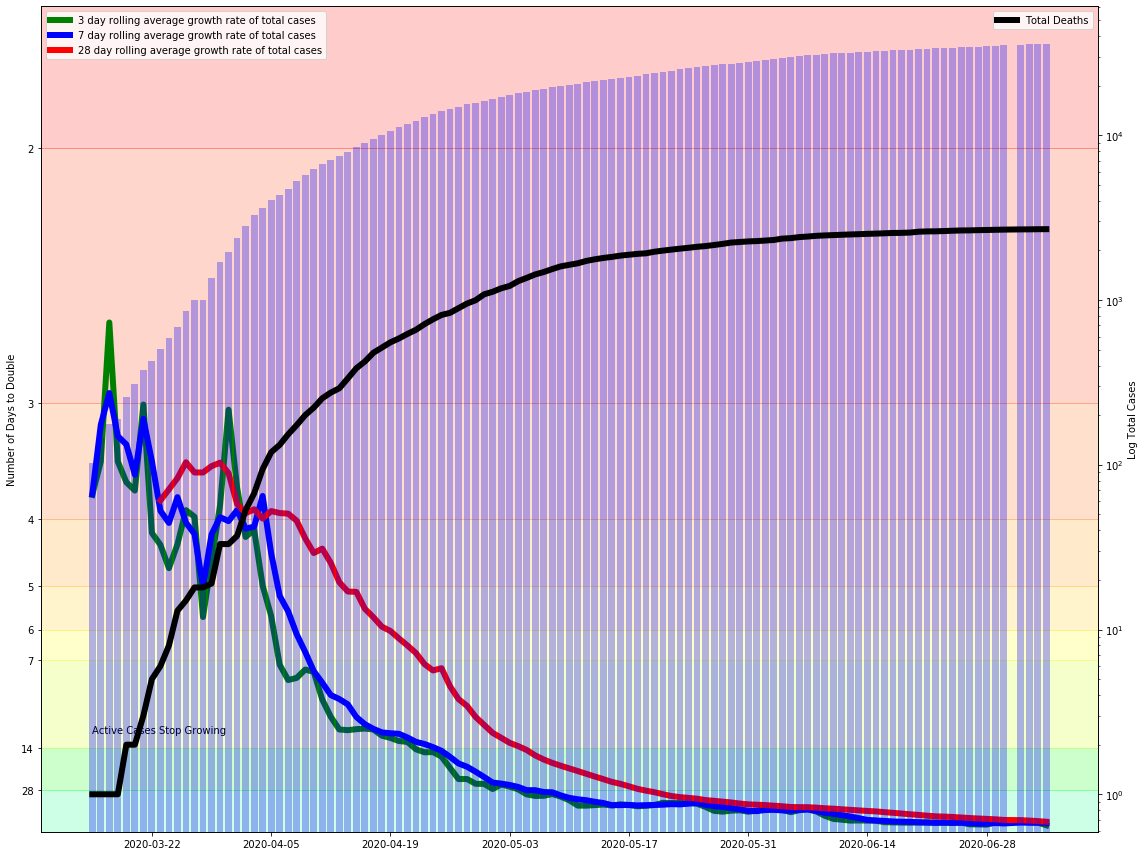

In [18]:
fig = can.plot_location('Ontario', from_date="2020-03-15")

plt.show()

# World

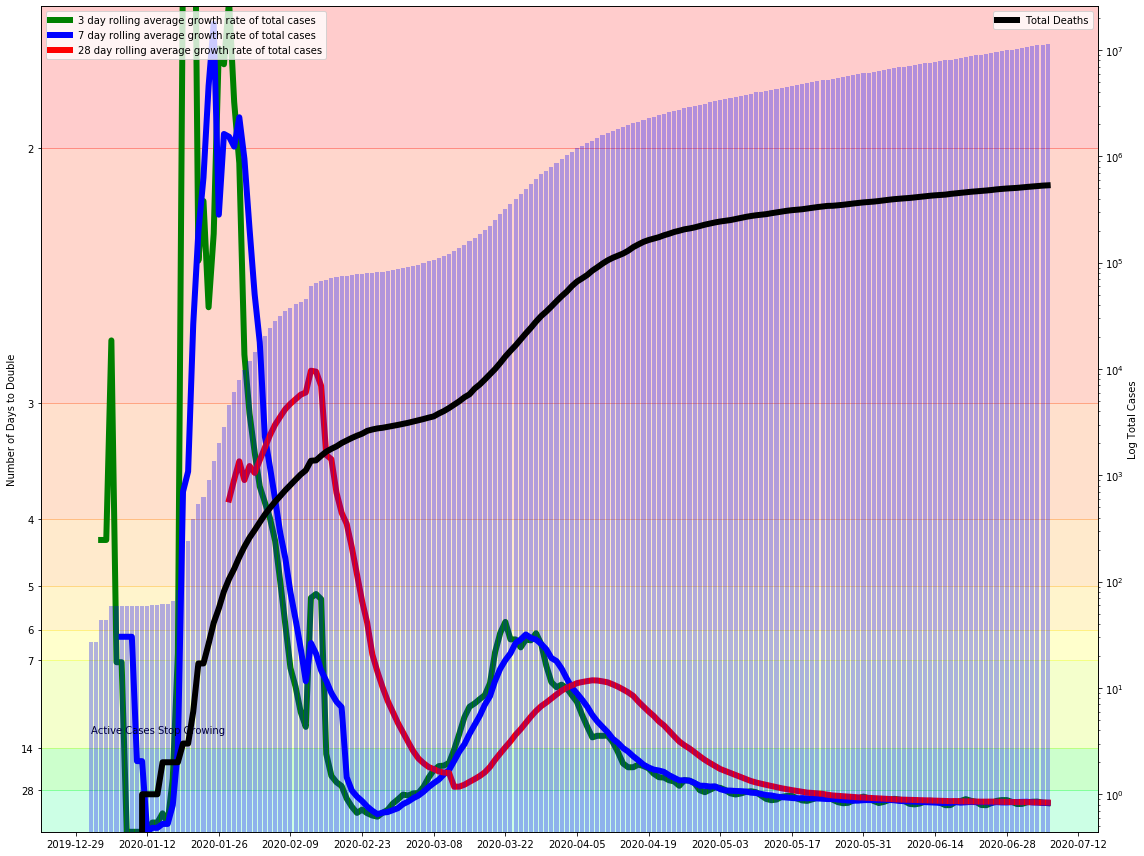

In [19]:
from src.ecdc import ECDC

world = ECDC()
fig = world.plot_location('World', from_date="2020-01-01")

plt.show()

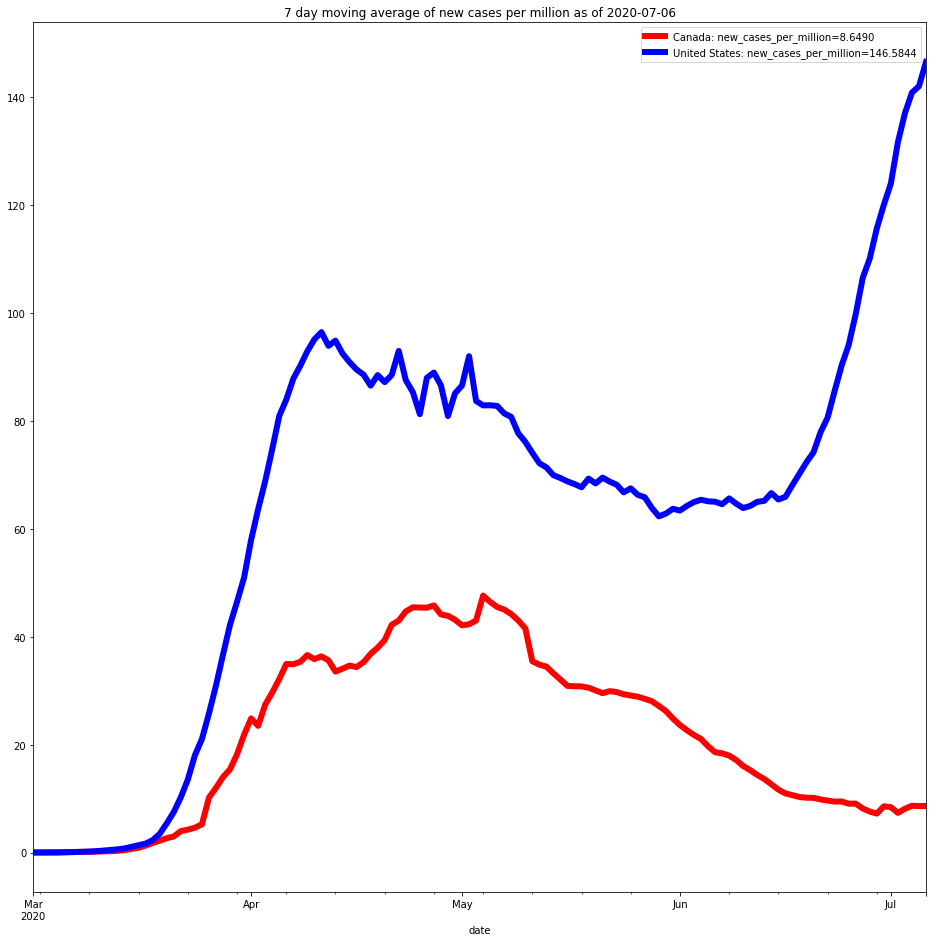

In [20]:
ma_win = 7
us_nc_fig = world.plot_var("new_cases_per_million", 'United States', 'Canada', ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    date_start="2020-03-01",
    date_end=as_of,
    colours={'United States': 'blue', 'Canada': 'red'},
    lw=6,
    title=f"{ma_win} day moving average of new cases per million as of {as_of}"  
)

savefile = f"{as_of}_US_CAN_NC_{ma_win}-Day_MA.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

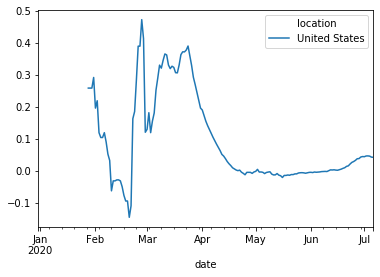

In [29]:
us_active_growth = world.active_growth_rate(7,"United States")
us_active_growth.plot()

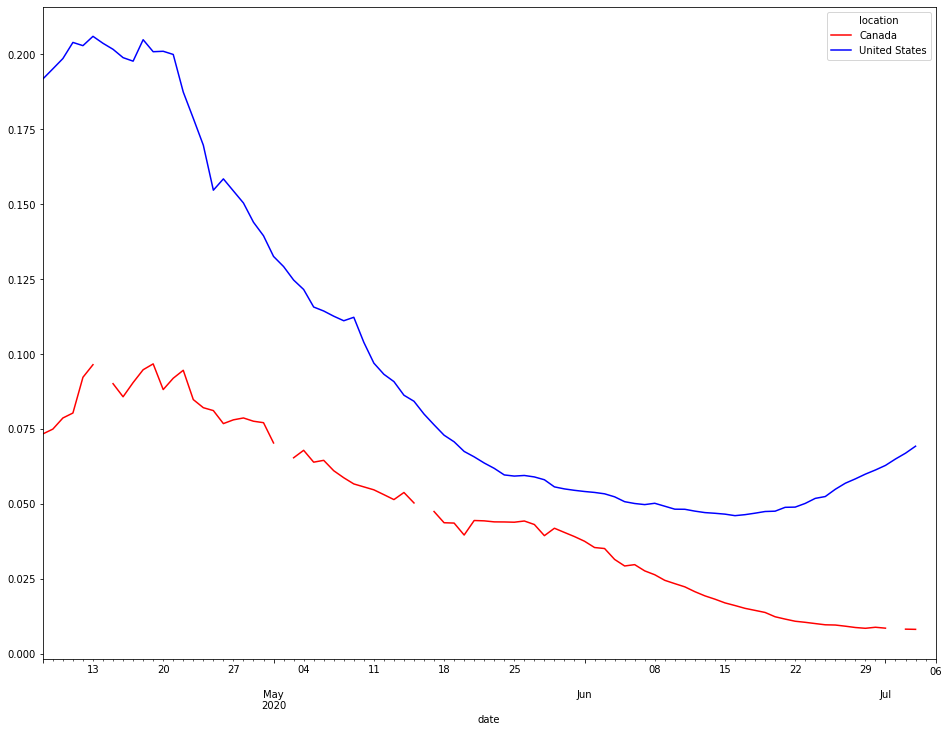

In [36]:
# Plot the positive test rate over the last ma_win days
ma_win = 14
locations = ['Canada', 'United States']

world_nt_rtot = world.var_by_location("total_tests", *locations).diff(periods=ma_win)
world_nc_rtot = world.var_by_location("total_cases", *locations).diff(periods=ma_win)
world_pt_rolling = world_nc_rtot / (1 * world_nt_rtot)

world_pt_rolling[-90:].plot(figsize=(16,12),color=["red", "blue"])

savefile = f"{as_of}_US_CAN_PT_rate.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

In [22]:
world_nc_rtot[-21:]

location,Canada,United States
date,,
2020-06-16,7442.0,302749.0
2020-06-17,7057.0,305910.0
2020-06-18,6768.0,311770.0
2020-06-19,6494.0,318392.0
2020-06-20,6294.0,323123.0
2020-06-21,5962.0,335058.0
2020-06-22,5638.0,338549.0
2020-06-23,5404.0,351117.0
2020-06-24,5321.0,367172.0


[[nan nan]]
['Canada', 'United States']


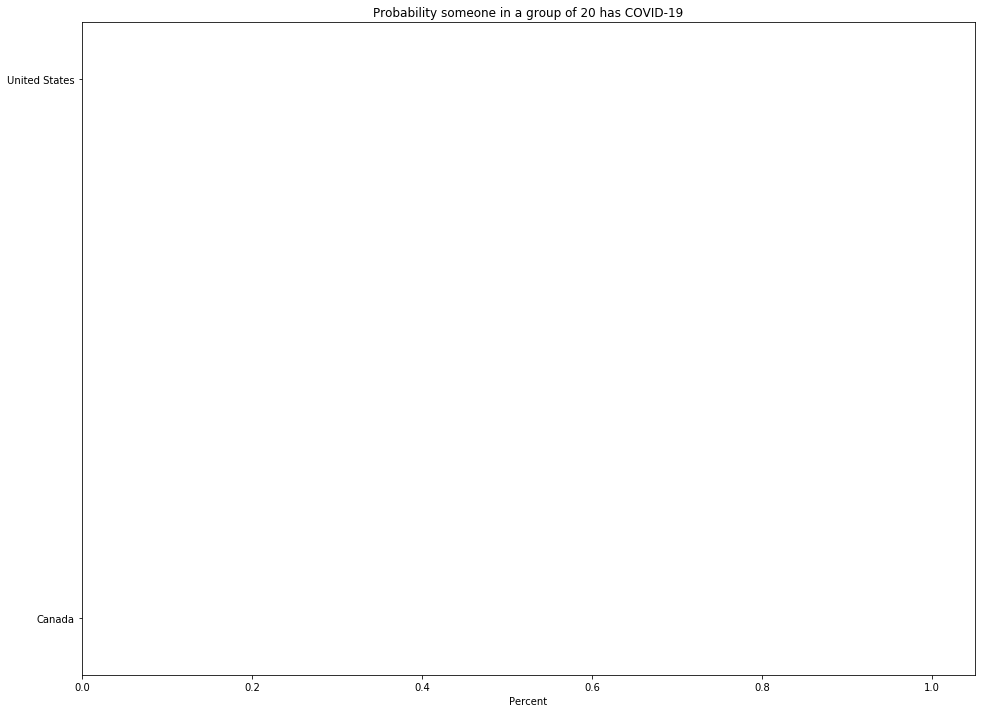

In [23]:
def prob_exposure(group_size, ptr):
    return 1 - np.power(1 - ptr, group_size)

group_size = 20
world_pe = world_pt_rolling.apply(lambda ptr: prob_exposure(group_size, ptr))

print(world_pe[-1:].values)
print(list(world_pe.columns))


pe_fig, pe_ax = plt.subplots(figsize=(16,12))

pe_ax.barh(list(world_pe.columns), 100 * world_pe[-1:].values[0])
pe_ax.set_xlabel("Percent")
pe_ax.set_title(f"Probability someone in a group of {group_size} has COVID-19")

savefile = f"{as_of}_COVID-19_WorldProbExp_{group_size}.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

In [24]:
countries = ['Canada', 
             'China', 
             'United States', 
             'Italy', 
             'Spain', 
             'United Kingdom', 
             'Germany',
             'Russia']

world.cum_pos_test_rate(*countries)[-7:]

location,Canada,China,Germany,Italy,Russia,Spain,United Kingdom,United States
date,,,,,,,,
2020-06-30,0.038179,NaN,0.033073,0.044607,0.032775,0.071833,0.063599,0.080436
2020-07-01,0.037614,NaN,0.033153,0.044179,0.032634,0.071945,0.063739,0.080251
2020-07-02,0.037091,NaN,0.033238,0.043785,0.032446,0.072073,0.063908,0.080212
2020-07-03,0.036782,NaN,0.033314,0.043426,0.032329,0.072200,0.057848,0.080082
2020-07-04,0.036414,NaN,0.033386,0.043062,0.032183,0.072200,0.057954,0.080162
2020-07-05,0.036492,NaN,0.033427,0.043104,0.032503,0.072200,0.058081,0.081459
2020-07-06,0.036568,NaN,0.033464,0.043138,0.032828,NaN,0.058186,0.082868


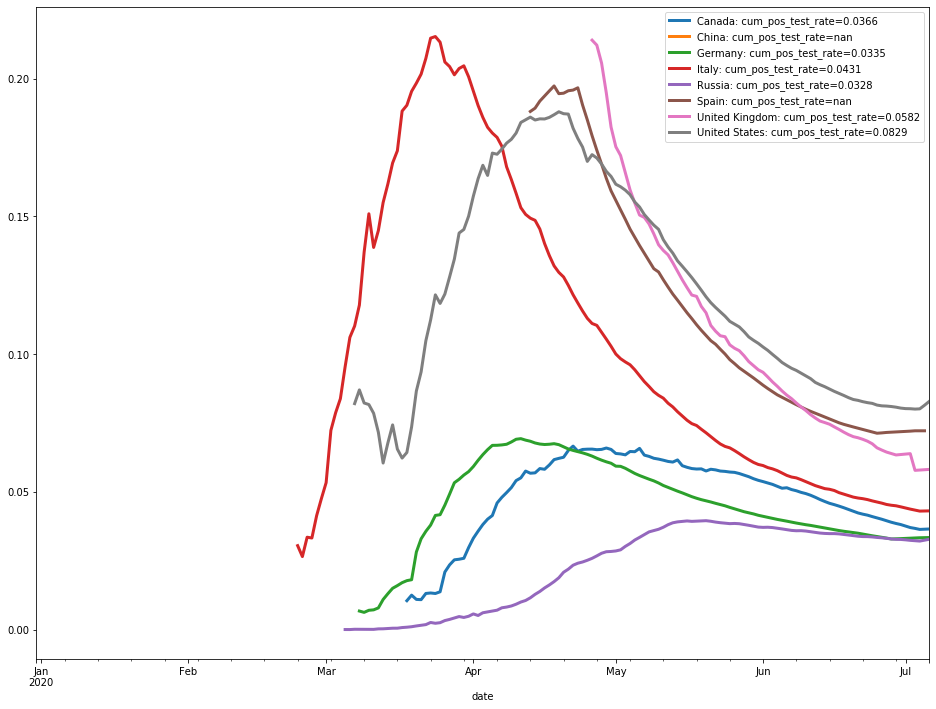

In [25]:
world.plot_var("cum_pos_test_rate", *countries)

plt.show()

In [26]:
world.get_location('China')[['total_tests', 'tests_units', 'total_tests_per_thousand']]

,total_tests,tests_units,total_tests_per_thousand
5453,NaN,NaN,NaN
5454,NaN,NaN,NaN
5455,NaN,NaN,NaN
5456,NaN,NaN,NaN
5457,NaN,NaN,NaN
...,...,...,...
5637,NaN,NaN,NaN
5638,NaN,NaN,NaN
5639,NaN,NaN,NaN
5640,NaN,NaN,NaN


In [27]:
world.df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy'],
      dtype='object')

In [28]:
fig = plt.figure(figsize=(16,12))

fig.add_axes()
fig.get_axes()

#ax1 = world.plot_var("total_cases_growth", 'Canada')
#ax2 = world.plot_var("total_cases", 'Canada')

[]

<Figure size 1152x864 with 0 Axes>